In [9]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [10]:
!pip install lib/kaggle-rig-0.2.0.tar.gz
import krig
krig.seed_everything()

Processing ./lib/kaggle-rig-0.2.0.tar.gz
  Created wheel for kaggle-rig: filename=kaggle_rig-0.2.0-py3-none-any.whl size=6539 sha256=a3e3bf26e1a5144b471341d773d908b0fdafa717f531a752e376081c74bea76e
  Stored in directory: /home/pankun/.cache/pip/wheels/03/99/72/07676e0abd65551d5261aee9360ad1c85fcaca1c409857a40a
Successfully built kaggle-rig
  Attempting uninstall: kaggle-rig
    Found existing installation: kaggle-rig 0.2.0
    Uninstalling kaggle-rig-0.2.0:
      Successfully uninstalled kaggle-rig-0.2.0


In [11]:
FOLDS = 10
ESTIMATORS = 1000
DATA = 'input/processed'
TARGET = ['fvc_last_3', 'fvc_last_2', 'fvc_last_1']
NON_FEATURES = set(TARGET) | {'pid', 'week_last_1', 'week_last_2', 'week_last_3'}
CATEGORICALS = {'sex', 'smoking'}
SCORING = 'neg_root_mean_squared_error'

In [12]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [13]:
train = pd.read_parquet(f'{DATA}/cvtrain.parquet')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pid                    174 non-null    object 
 1   age                    174 non-null    uint8  
 2   sex                    174 non-null    object 
 3   smoking                174 non-null    object 
 4   week_1                 174 non-null    int16  
 5   fvc_1                  174 non-null    uint16 
 6   percent_1              174 non-null    float32
 7   fvc_last_1             174 non-null    uint16 
 8   fvc_last_2             174 non-null    uint16 
 9   fvc_last_3             174 non-null    uint16 
 10  week_last_1            174 non-null    int16  
 11  week_last_2            174 non-null    int16  
 12  week_last_3            174 non-null    int16  
 13  fvc_last_1_min         174 non-null    float32
 14  fvc_last_1_p50         174 non-null    float32
 15  fvc_la

In [14]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,fvc_last_1_min,fvc_last_1_p50,fvc_last_1_p75,fvc_last_1_p90,fvc_last_1_p95,fvc_last_1_p99,fvc_last_1_max,fvc_last_2_min,fvc_last_2_p50,fvc_last_2_p75,fvc_last_2_p90,fvc_last_2_p95,fvc_last_2_p99,fvc_last_2_max,fvc_last_3_min,fvc_last_3_p50,fvc_last_3_p75,fvc_last_3_p90,fvc_last_3_p95,fvc_last_3_p99,fvc_last_3_max,lung_area_min,lung_area_p50,lung_area_p75,lung_area_p90,lung_area_p95,lung_area_p99,lung_area_max,tissue_area_min,tissue_area_p50,tissue_area_p75,tissue_area_p90,tissue_area_p95,tissue_area_p99,tissue_area_max,lung_tissue_ratio_min,lung_tissue_ratio_p50,lung_tissue_ratio_p75,lung_tissue_ratio_p90,lung_tissue_ratio_p95,lung_tissue_ratio_p99,lung_tissue_ratio_max
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,765.971436,933.130981,953.146179,982.087036,1026.730347,1029.991699,1031.133423,814.164551,991.532471,1012.845459,1043.541260,1090.911011,1094.411865,1095.622437,779.107544,949.013916,969.371826,998.783386,1044.162842,1047.498535,1048.665771,670.0,1656.0,2391.25,2693.100098,2721.350098,2828.399902,2869.0,4255.0,6106.0,9372.75,11325.299805,12560.299805,13245.419922,13333.0,0.059491,0.256664,0.446996,0.568525,0.573278,0.626535,0.647630
1,ID00009637202177434476278,69,Male,Ex-smoker,8,3660,85.282875,3214,3390,3625,60,45,33,828.815674,1186.416382,1234.455811,1272.800659,1283.808105,1314.483032,1337.459961,880.681580,1260.471191,1311.541992,1352.224854,1363.890991,1396.443970,1420.825684,842.963562,1206.461426,1255.335449,1294.297119,1305.480835,1336.656006,1360.012939,704.0,2156.5,2867.00,3206.899902,3339.449951,3478.419922,3523.0,9535.0,11885.5,16274.00,18535.300781,19007.099609,19512.429688,19734.0,0.039308,0.198787,0.255620,0.288663,0.300436,0.322504,0.335254
2,ID00010637202177584971671,60,Male,Ex-smoker,0,3523,94.724670,2518,2474,2993,54,37,25,805.432922,1086.497314,1149.963623,1193.561523,1235.537354,1248.815674,1267.994629,856.017456,1154.435059,1221.777588,1268.091064,1312.594971,1326.702271,1347.058472,819.179810,1104.902588,1169.408813,1213.743652,1256.408203,1269.904785,1289.383179,232.0,1288.5,2612.75,3364.000000,3721.250000,4241.149902,4315.0,6774.0,10859.0,12289.00,15495.000000,16202.750000,16849.349609,16897.0,0.013873,0.115833,0.317440,0.443931,0.488324,0.562757,0.585732
3,ID00012637202177665765362,65,Male,Never smoked,33,3418,93.726006,2971,3231,3324,87,71,58,694.511475,1168.249146,1218.414551,1257.296265,1271.723022,1285.077393,1291.298828,738.171753,1241.294434,1294.546387,1335.746948,1351.042725,1365.269531,1371.894409,706.410339,1188.028564,1239.028442,1278.556519,1293.227051,1306.791504,1313.117310,204.0,1129.0,1826.00,2223.399902,2491.600098,2976.679932,3089.0,5799.0,7015.0,8992.00,10425.000000,10657.200195,11110.839844,11371.0,0.024120,0.147254,0.295255,0.343806,0.391733,0.479589,0.516469
4,ID00014637202177757139317,56,Male,Ex-smoker,0,3807,90.076660,3027,3439,3221,54,37,26,610.222473,1035.294678,1104.844971,1139.776611,1140.848145,1149.658691,1153.010742,649.051025,1100.190552,1174.064209,1211.074341,1212.302490,1221.626343,1225.156982,620.810120,1052.893799,1123.614746,1159.086182,1160.229980,1169.166504,1172.555786,516.0,1537.0,2958.50,3736.000000,4082.000000,5042.600098,5360.0,7745.0,10419.0,13426.50,17834.000000,18872.000000,19514.500000,19651.0,0.028359,0.143710,0.316701,0.432157,0.452699,0.625855,0.692059


In [15]:
def encode(df, col, encoder) -> None:
    df[col] = df[col].map(encoder).fillna(0)
    assert not df[col].isna().any()

 
for col in CATEGORICALS:
    encoder = dict(train[col].value_counts(normalize=True))
    print(f'col={col}, encoder={encoder}')
    encode(train, col, encoder)

col=sex, encoder={'Male': 0.7873563218390804, 'Female': 0.21264367816091953}
col=smoking, encoder={'Ex-smoker': 0.6666666666666666, 'Never smoked': 0.28160919540229884, 'Currently smokes': 0.05172413793103448}


In [16]:
FEATURES = set(train.columns) - NON_FEATURES
FEATURES = list(FEATURES)
FEATURES.sort()
print(f'{len(FEATURES)} FEATURES={FEATURES}')

48 FEATURES=['age', 'fvc_1', 'fvc_last_1_max', 'fvc_last_1_min', 'fvc_last_1_p50', 'fvc_last_1_p75', 'fvc_last_1_p90', 'fvc_last_1_p95', 'fvc_last_1_p99', 'fvc_last_2_max', 'fvc_last_2_min', 'fvc_last_2_p50', 'fvc_last_2_p75', 'fvc_last_2_p90', 'fvc_last_2_p95', 'fvc_last_2_p99', 'fvc_last_3_max', 'fvc_last_3_min', 'fvc_last_3_p50', 'fvc_last_3_p75', 'fvc_last_3_p90', 'fvc_last_3_p95', 'fvc_last_3_p99', 'lung_area_max', 'lung_area_min', 'lung_area_p50', 'lung_area_p75', 'lung_area_p90', 'lung_area_p95', 'lung_area_p99', 'lung_tissue_ratio_max', 'lung_tissue_ratio_min', 'lung_tissue_ratio_p50', 'lung_tissue_ratio_p75', 'lung_tissue_ratio_p90', 'lung_tissue_ratio_p95', 'lung_tissue_ratio_p99', 'percent_1', 'sex', 'smoking', 'tissue_area_max', 'tissue_area_min', 'tissue_area_p50', 'tissue_area_p75', 'tissue_area_p90', 'tissue_area_p95', 'tissue_area_p99', 'week_1']


In [17]:
x_train = train[FEATURES]

In [18]:
%%time
models = []
results = []


for col in TARGET:
    y_train = train[col]
    model = lgb.LGBMRegressor(n_estimators=ESTIMATORS, reg_alpha=1)
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__learning_rate': [0.01, 0.001],
        'model__subsample': [0.01, 0.05, 0.1],
        'model__min_child_samples': [20, 40, 80],
        'model__colsample_bytree': [0.2, 0.3, 0.4]
    }
    lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
    lgbm.fit(x_train, y_train)
    best_score = lgbm.best_score_
    best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
    print(f"""LGBM y={col}
best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
    """)
    res = pd.DataFrame.from_dict(lgbm.cv_results_)
    res.set_index('rank_test_score', inplace=True)
    res.sort_index(inplace=True)
    models.append(lgbm)
    results.append(res)

LGBM y=fvc_last_3
best params={'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
best score=-322.915, std=71.431
    
LGBM y=fvc_last_2
best params={'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
best score=-356.683, std=76.933
    
LGBM y=fvc_last_1
best params={'model__colsample_bytree': 0.4, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__subsample': 0.01}
best score=-370.661, std=84.740
    
CPU times: user 9min 42s, sys: 20.7 s, total: 10min 3s
Wall time: 1min 41s


In [19]:
results[0].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.111073,0.007580,0.001836,0.000054,0.4,0.01,20,0.05,"{'model__colsample_bytree': 0.4, 'model__learn...",-370.569578,-307.138488,-351.985335,-269.000449,-320.356743,-496.468883,-275.143913,-214.192662,-324.206059,-300.092504,-322.915461,71.431346
1,0.109018,0.003813,0.001828,0.000054,0.4,0.01,20,0.01,"{'model__colsample_bytree': 0.4, 'model__learn...",-370.569578,-307.138488,-351.985335,-269.000449,-320.356743,-496.468883,-275.143913,-214.192662,-324.206059,-300.092504,-322.915461,71.431346
1,0.109521,0.002111,0.001862,0.000079,0.4,0.01,20,0.1,"{'model__colsample_bytree': 0.4, 'model__learn...",-370.569578,-307.138488,-351.985335,-269.000449,-320.356743,-496.468883,-275.143913,-214.192662,-324.206059,-300.092504,-322.915461,71.431346
4,0.105610,0.001303,0.001868,0.000045,0.3,0.01,20,0.05,"{'model__colsample_bytree': 0.3, 'model__learn...",-375.364044,-330.570837,-357.687824,-283.925263,-323.796078,-504.888309,-278.328195,-229.524418,-353.043101,-314.745651,-335.187372,69.879924
4,0.105697,0.001552,0.001815,0.000038,0.3,0.01,20,0.1,"{'model__colsample_bytree': 0.3, 'model__learn...",-375.364044,-330.570837,-357.687824,-283.925263,-323.796078,-504.888309,-278.328195,-229.524418,-353.043101,-314.745651,-335.187372,69.879924
4,0.106916,0.003369,0.001875,0.000057,0.3,0.01,20,0.01,"{'model__colsample_bytree': 0.3, 'model__learn...",-375.364044,-330.570837,-357.687824,-283.925263,-323.796078,-504.888309,-278.328195,-229.524418,-353.043101,-314.745651,-335.187372,69.879924
7,0.114051,0.017176,0.002264,0.001291,0.2,0.01,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-383.516902,-374.406266,-407.539959,-321.943272,-340.991081,-535.138813,-292.858775,-264.479323,-391.202791,-370.064937,-368.214212,70.381971
7,0.105675,0.004697,0.001915,0.000164,0.2,0.01,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-383.516902,-374.406266,-407.539959,-321.943272,-340.991081,-535.138813,-292.858775,-264.479323,-391.202791,-370.064937,-368.214212,70.381971
7,0.103520,0.003738,0.001867,0.000098,0.2,0.01,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-383.516902,-374.406266,-407.539959,-321.943272,-340.991081,-535.138813,-292.858775,-264.479323,-391.202791,-370.064937,-368.214212,70.381971


In [20]:
results[1].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.109006,0.001868,0.001895,0.000133,0.4,0.01,20,0.05,"{'model__colsample_bytree': 0.4, 'model__learn...",-377.348963,-350.528073,-363.418504,-287.384538,-356.707329,-559.509577,-366.422729,-268.359776,-349.676279,-287.472621,-356.682839,76.932603
1,0.111544,0.004968,0.001853,0.000057,0.4,0.01,20,0.01,"{'model__colsample_bytree': 0.4, 'model__learn...",-377.348963,-350.528073,-363.418504,-287.384538,-356.707329,-559.509577,-366.422729,-268.359776,-349.676279,-287.472621,-356.682839,76.932603
1,0.114289,0.009155,0.001878,0.000060,0.4,0.01,20,0.1,"{'model__colsample_bytree': 0.4, 'model__learn...",-377.348963,-350.528073,-363.418504,-287.384538,-356.707329,-559.509577,-366.422729,-268.359776,-349.676279,-287.472621,-356.682839,76.932603
4,0.106615,0.001756,0.001895,0.000122,0.3,0.01,20,0.05,"{'model__colsample_bytree': 0.3, 'model__learn...",-381.131730,-369.687615,-368.771134,-313.726512,-354.720661,-567.266698,-377.363595,-262.916811,-355.532892,-310.892319,-366.200997,75.841651
4,0.106729,0.002164,0.001862,0.000084,0.3,0.01,20,0.1,"{'model__colsample_bytree': 0.3, 'model__learn...",-381.131730,-369.687615,-368.771134,-313.726512,-354.720661,-567.266698,-377.363595,-262.916811,-355.532892,-310.892319,-366.200997,75.841651
4,0.106343,0.004327,0.001911,0.000210,0.3,0.01,20,0.01,"{'model__colsample_bytree': 0.3, 'model__learn...",-381.131730,-369.687615,-368.771134,-313.726512,-354.720661,-567.266698,-377.363595,-262.916811,-355.532892,-310.892319,-366.200997,75.841651
7,0.116744,0.029465,0.004363,0.007368,0.2,0.01,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-394.186804,-391.867589,-405.207743,-354.925549,-394.538030,-574.233676,-387.995804,-304.273551,-388.990212,-334.465205,-393.068416,67.667698
7,0.103650,0.002116,0.001897,0.000091,0.2,0.01,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-394.186804,-391.867589,-405.207743,-354.925549,-394.538030,-574.233676,-387.995804,-304.273551,-388.990212,-334.465205,-393.068416,67.667698
7,0.102927,0.001435,0.001857,0.000059,0.2,0.01,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-394.186804,-391.867589,-405.207743,-354.925549,-394.538030,-574.233676,-387.995804,-304.273551,-388.990212,-334.465205,-393.068416,67.667698


In [21]:
results[2].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.109826,0.002477,0.001919,0.000160,0.4,0.01,20,0.05,"{'model__colsample_bytree': 0.4, 'model__learn...",-397.887296,-406.001856,-406.248853,-270.391486,-436.520437,-557.059106,-317.144065,-256.447571,-321.988799,-336.919516,-370.660899,84.740001
1,0.109062,0.001424,0.001897,0.000079,0.4,0.01,20,0.01,"{'model__colsample_bytree': 0.4, 'model__learn...",-397.887296,-406.001856,-406.248853,-270.391486,-436.520437,-557.059106,-317.144065,-256.447571,-321.988799,-336.919516,-370.660899,84.740001
1,0.114908,0.006204,0.001909,0.000100,0.4,0.01,20,0.1,"{'model__colsample_bytree': 0.4, 'model__learn...",-397.887296,-406.001856,-406.248853,-270.391486,-436.520437,-557.059106,-317.144065,-256.447571,-321.988799,-336.919516,-370.660899,84.740001
4,0.106266,0.001371,0.001878,0.000092,0.3,0.01,20,0.05,"{'model__colsample_bytree': 0.3, 'model__learn...",-391.640393,-424.017657,-425.106536,-273.114419,-442.893298,-556.074952,-321.727079,-251.646698,-330.907132,-349.862370,-376.699053,85.772876
4,0.107106,0.002744,0.001866,0.000065,0.3,0.01,20,0.1,"{'model__colsample_bytree': 0.3, 'model__learn...",-391.640393,-424.017657,-425.106536,-273.114419,-442.893298,-556.074952,-321.727079,-251.646698,-330.907132,-349.862370,-376.699053,85.772876
4,0.109615,0.010569,0.001875,0.000056,0.3,0.01,20,0.01,"{'model__colsample_bytree': 0.3, 'model__learn...",-391.640393,-424.017657,-425.106536,-273.114419,-442.893298,-556.074952,-321.727079,-251.646698,-330.907132,-349.862370,-376.699053,85.772876
7,0.112027,0.011973,0.001919,0.000078,0.2,0.01,20,0.01,"{'model__colsample_bytree': 0.2, 'model__learn...",-366.784379,-465.884437,-479.841194,-307.269935,-480.011731,-567.859608,-325.554280,-269.361804,-350.974248,-371.749896,-398.529151,89.880312
7,0.103833,0.002008,0.001871,0.000071,0.2,0.01,20,0.05,"{'model__colsample_bytree': 0.2, 'model__learn...",-366.784379,-465.884437,-479.841194,-307.269935,-480.011731,-567.859608,-325.554280,-269.361804,-350.974248,-371.749896,-398.529151,89.880312
7,0.104504,0.002649,0.001845,0.000055,0.2,0.01,20,0.1,"{'model__colsample_bytree': 0.2, 'model__learn...",-366.784379,-465.884437,-479.841194,-307.269935,-480.011731,-567.859608,-325.554280,-269.361804,-350.974248,-371.749896,-398.529151,89.880312


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

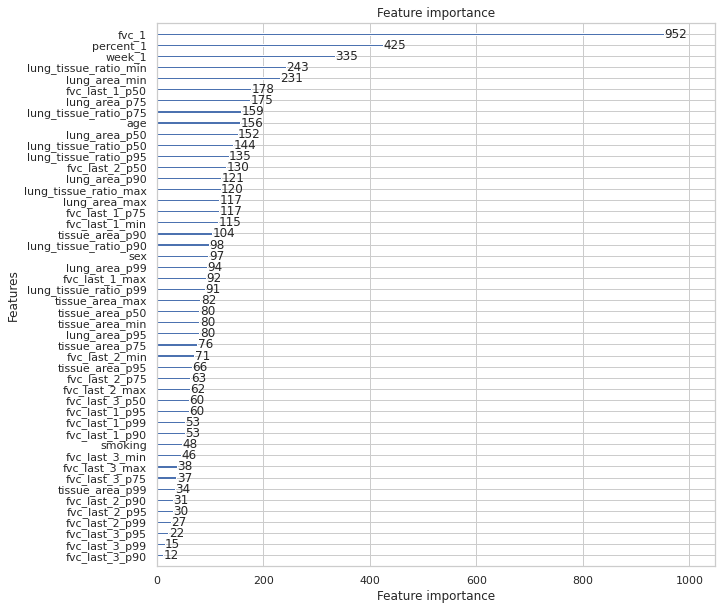

In [22]:
lgb.plot_importance(models[0].best_estimator_['model'], figsize=(10, 10))
    

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

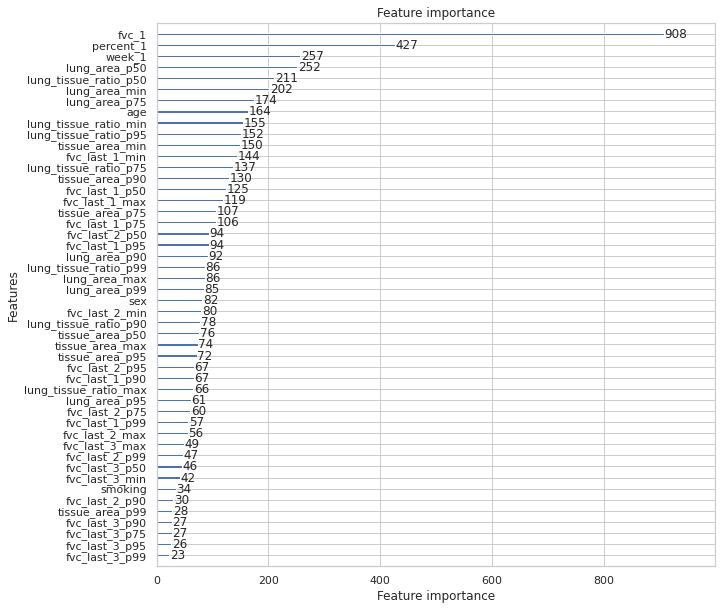

In [23]:
lgb.plot_importance(models[1].best_estimator_['model'], figsize=(10, 10))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

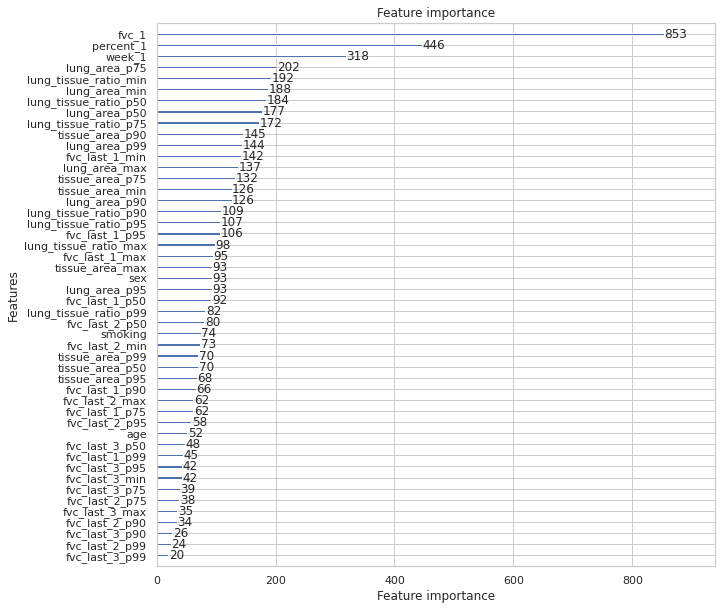

In [24]:
lgb.plot_importance(models[2].best_estimator_['model'], figsize=(10, 10))

In [25]:
for i in range(len(models)):
    y = TARGET[i]
    lgbm = models[i]
    lgbm.best_estimator_['model'].booster_.save_model(f'output/lgb_{y}.txt')